# Topic: Convolutional Neural Networks

# Init

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Flatten, Input, Resizing, Conv2D, MaxPooling2D, Layer
from keras import regularizers
from keras.models import Model, clone_model
from keras import models
from keras.applications import efficientnet, mobilenet_v3
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import types
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Tuple
import keras_cv
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageOps, Image, ImageEnhance
sns.set_theme()
import pickle
import math

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

IMAGE_SIZE  = x_train.shape[1:]
CLASS_COUNT = 10

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Model training

In [77]:
METRICS = [CategoricalAccuracy(), Precision(name="precision"), Recall(name="recall")]
def make_feature_extractor(*steps: list[Model], freeze=False) -> Model:
    if freeze:
        for layer in steps[-1].layers:
            layer.trainable = False

    def pseudo_layer(x):
        for step in steps:
            x = step(x)
        return x
    return pseudo_layer


class Settings:
    first_dense_layer_size   = 64
    second_dense_layer_size  = 32
    dropout_rate             = 0.5
    learning_rate            = 0.01
    batch_size               = 64
    epochs                   = 100
    early_stopping_patience  = 3
    early_stopping_min_delta = 0.005
    l2                       = 0
    augmentation             = "none"
    augmentation_percentage  = 0.5

    def __init__(self, **kwargs):
        default_values = {
            k: v for k, v in vars(Settings).items() 
            if not isinstance(v, (types.FunctionType, types.MethodType))
            and not k.startswith('_')
        }
        for k, v in default_values.items():
            setattr(self, k, v)
        for k, v in kwargs.items():
            if k not in default_values:
                raise ValueError(f"Unknown parameter {k}")
            setattr(self, k, v)
        self._diff = kwargs

class Experiment:
    feature_extractors = {}
    augmentations = {}

    @staticmethod
    def register_feature_extractor(name: str, feature_extractor: Model):
        Experiment.feature_extractors[name] = feature_extractor

    @staticmethod
    def select_feature_extractor(name: str):
        Experiment.feature_extractors = {name: Experiment.feature_extractors[name]}

    @staticmethod
    def register_augmentation(name: str, augmentation: Callable):
        Experiment.augmentations[name] = augmentation
        
        images, _ = augmentation(x_train[:25], y_train[:25])
        plt.figure(figsize=(10, 10))
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].astype("uint8"))
            plt.axis("off")
        plt.show()

    @staticmethod
    def run(settings_list=None, *, repeat_count = 2) -> pd.DataFrame:
        if settings_list is None:
            settings_list = [Settings()]
        results = pd.DataFrame()
        for settings in settings_list:
            worker = ExperimentWorker(settings)
            for name, feature_extractor in Experiment.feature_extractors.items():
                for i in range(repeat_count):
                    results = pd.concat([
                        results, 
                        pd.DataFrame([{
                            'model': name,
                            'iteration': i,
                            **settings._diff,
                            **worker.run(feature_extractor)
                        }])], 
                        ignore_index=True
                    )

        return results
    
    

class ExperimentWorker:
    def __init__(self, settings: Settings):
        self._ = settings

    def run(self, feature_extractor: Model) -> pd.DataFrame:
        model = self.build_model(feature_extractor)
        self.train_model(model)
        return self.evaluate_model(model)

    def build_model(self, feature_extractor: Model) -> Model:
        i = Input(IMAGE_SIZE, dtype = tf.uint8)
        x = feature_extractor()(i)
        x = self.make_classifier(x)

        return Model(inputs=[i], outputs=x)

    def make_classifier(self, x: Model) -> Model:
        x = Flatten()(x)
        x = Dense(self._.first_dense_layer_size, activation = 'relu', kernel_regularizer=regularizers.l2(self._.l2))(x)
        x = Dropout(self._.dropout_rate)(x)
        x = Dense(self._.second_dense_layer_size, activation = 'relu', kernel_regularizer=regularizers.l2(self._.l2))(x)
        x = Dropout(self._.dropout_rate)(x)

        return Dense(CLASS_COUNT, activation='softmax')(x)

    def train_model(self, model: Model) -> pd.DataFrame:
        model.compile(
            optimizer = SGD(learning_rate = self._.learning_rate), 
            loss      = 'categorical_crossentropy',
            metrics   = METRICS
        )

        early_stop = EarlyStopping(
            monitor   = 'val_loss', 
            patience  = self._.early_stopping_patience, 
            min_delta = self._.early_stopping_min_delta
        )
        
        history = model.fit(
            *self.augment_data(x_train, y_train), 
            batch_size       = int(self._.batch_size), 
            epochs           = self._.epochs, 
            validation_data  = (x_val, y_val),
            callbacks        = [early_stop]
        )
        return history

    def augment_data(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        x = np.array(x)
        y = np.array(y)

        if self._.augmentation == "none":
            return x, y
        elif self._.augmentation in Experiment.augmentations:
            selection = np.random.choice(x.shape[0], int(self._.augmentation_percentage * x.shape[0]), replace=False)
            aug_x, aug_y = Experiment.augmentations[self._.augmentation](x[selection], y[selection])
            x = np.concatenate([x, aug_x])
            y = np.concatenate([y, aug_y])
            
            p = np.random.permutation(x.shape[0])
            return x[p], y[p]
        else:
            raise ValueError(f"Unknown augmentation type {self._.augmentation}")

    def evaluate_model(self, model: Model):
        raw_results = model.evaluate(x_test, y_test)
        metrics = {model.metrics_names[i]: raw_results[i] for i in range(len(model.metrics_names))}
        predictions = model.predict(x_test)
        return {'predictions': predictions, **metrics}
    
    def predict_model(self, model: Model):
        predictions = model.predict(x_test)
        return predictions
        
def result_extractor(key_column: str):
    ignore_columns = ['model', 'predictions', 'loss', 'precision', 'recall', 'iteration']
    def extractor(results: pd.DataFrame) -> dict:
        results = results[[c for c in results.columns if c not in ignore_columns]]
        results = results.groupby([c for c in results.columns if c != key_column], as_index=False).mean()
        results = results.loc[results[key_column].idxmax()]
        results = results.drop(key_column).to_dict()  
        print(f"Current best grid search result: {results}")
        return results
    return extractor

## MobileNet (random initialization)

In [78]:
def make_mobilenet_random():
    print("Building MobileNet (random initialization)...")
    return make_feature_extractor(
        Resizing(128, 128),
        mobilenet_v3.preprocess_input,
        mobilenet_v3.MobileNetV3Small(include_top=False, input_shape=(128, 128, 3))
    )

Experiment.register_feature_extractor(
    'MobileNet (random initialization)', 
    make_mobilenet_random
)

## MobileNet (pretrained)

In [114]:
def make_mobilenet_pretrained():
    print("Building MobileNet (pretrained)...")
    return make_feature_extractor(
        Resizing(128, 128),
        mobilenet_v3.preprocess_input,
        mobilenet_v3.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
        freeze=True
    )

Experiment.register_feature_extractor(
    'MobileNet (pretrained)', 
    make_mobilenet_pretrained
)

## EfficientNet (pretrained)

In [115]:
def make_efficientnet_pretrained():
    print("Building EfficientNet (pretrained)...")
    return make_feature_extractor(
        Resizing(64, 64),
        efficientnet.preprocess_input,
        efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3)),
        freeze=True
    )

Experiment.register_feature_extractor(
    'EfficientNet (pretrained)',
    make_efficientnet_pretrained
)

## Custom CNN (3 VGG blocks)

In [116]:
class PrepData(Layer):
    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        inputs = inputs / 255.0
        return inputs

def make_custom_cnn():
    print("Building custom CNN...")
    model = models.Sequential()
    model.add(PrepData())

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=IMAGE_SIZE))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    return model

Experiment.register_feature_extractor(
    'Custom CNN (3 VGG blocks)',
    make_custom_cnn
)


# Data Augmentation

## Shifting

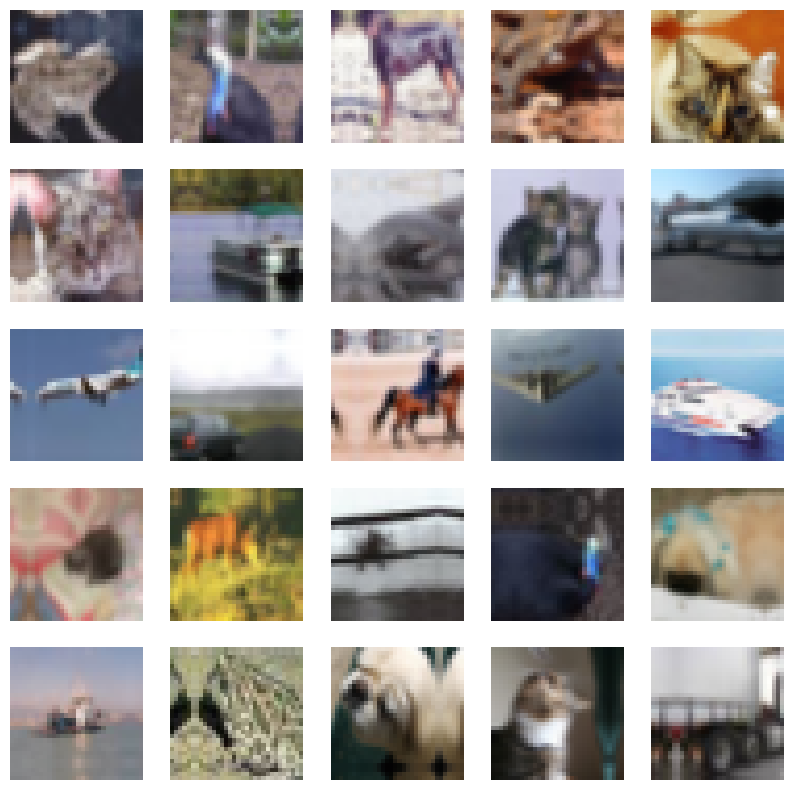

In [9]:
def augment_shift(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    if len(x.shape) == 3:
        x = np.expand_dims(x, axis=0)
    datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2, 
        fill_mode='reflect'
    )
    datagen.fit(x)
    x_aug = datagen.flow(x, batch_size=len(x), shuffle=False).next()
    return x_aug, y

Experiment.register_augmentation('shift', augment_shift)

## Cropping

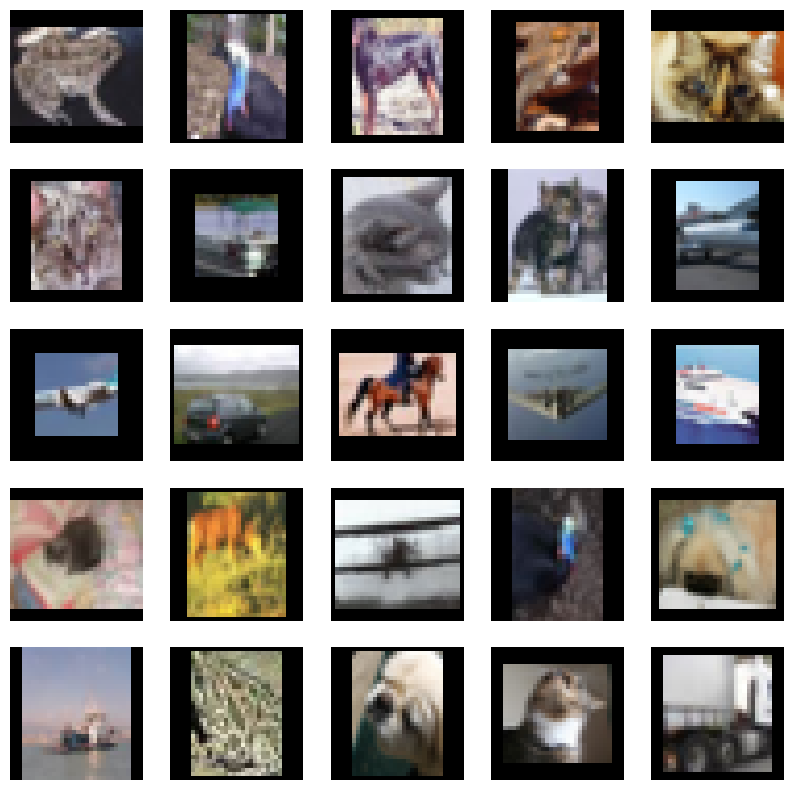

In [10]:
def augment_crop(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    def crop(image):
        image = Image.fromarray(image)
        widthBorder = round(image.size[0]*0.2*np.random.rand())
        heightBorder = round(image.size[1]*0.2*np.random.rand())
        image_cropped = image.crop((widthBorder, heightBorder, image.size[0]-widthBorder, image.size[1]-heightBorder))
        image_cropped = ImageOps.expand(image_cropped, (widthBorder, heightBorder, widthBorder, heightBorder), fill="black")
        return np.array(image_cropped)
    
    return [crop(img) for img in x], y
    

Experiment.register_augmentation('crop', augment_crop)

## Contrast

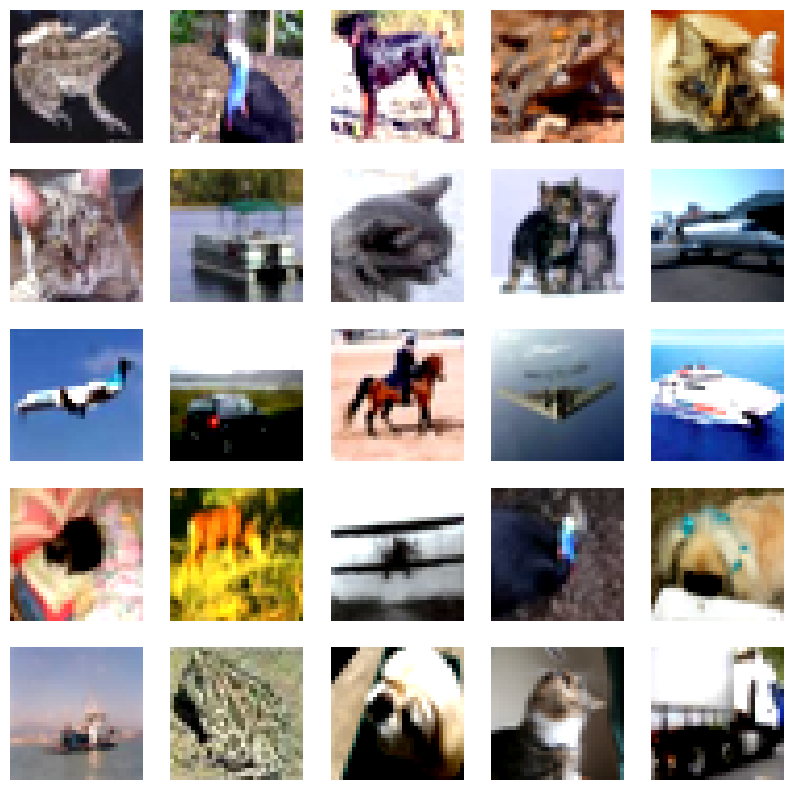

In [11]:
def augment_contrast(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    def increase_contrast(image):
        image = Image.fromarray(image)
        intensity = 0.1+np.random.rand()*0.9
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(1+intensity)
        return np.array(image)
    return [increase_contrast(img) for img in x], y

Experiment.register_augmentation('contrast', augment_contrast)

## Cut mix

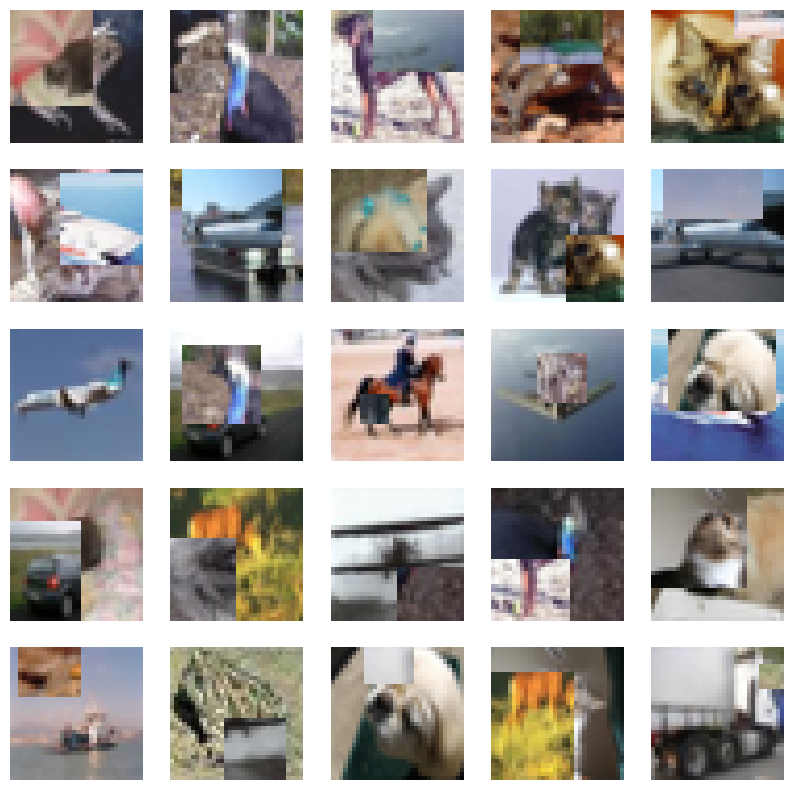

In [12]:
def augment_cutmix(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    cutmix = keras_cv.layers.preprocessing.cut_mix.CutMix()
    output = cutmix({"images": x, "labels": y}, training=True)
    x_aug, y_aug = np.array([i.numpy() for i in output["images"]]), output["labels"]
    return x_aug, y_aug

Experiment.register_augmentation('cutmix', augment_cutmix)

## All

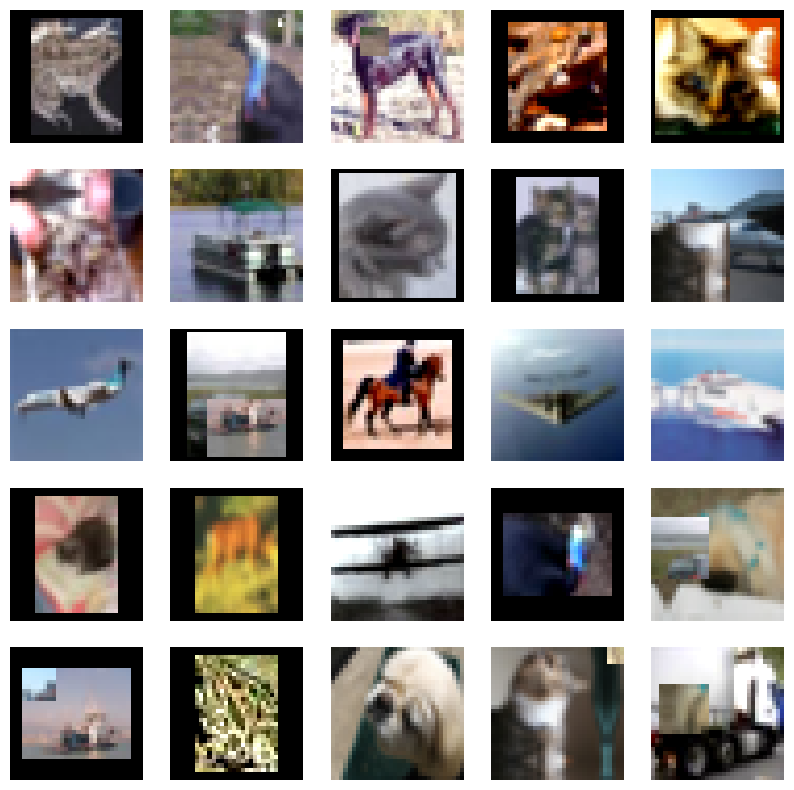

In [13]:
def augment_all(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    x = np.array(x)
    y = np.array(y)
    for name in ["shift", "contrast", "cutmix", "crop"]:
        selection = np.random.choice(x.shape[0], int(x.shape[0]/2), replace=False)
        x[selection], y[selection] = Experiment.augmentations[name](x[selection], y[selection])
    return x, y

Experiment.register_augmentation('all', augment_all)

# Experiments

**Description:** 

To obtain statistically significant results, each experiment ought to be repeated multiple times (when possible).

**Solution:**

Every expermient will be conducted 5 times.

## Experiment 1

**Description:** 

Investigate influence of the following hyper-parameter change on obtained results:

• At least 2 hyper-parameters related to training process (learning_rate, batch_size, momentum, number of epochs),

• At least 2 hyper-parameters related to regularization (dropout, l2, l1).

**Solution:** 

To obtain meaningful results we will create a grid of 4 hyperparameters and 5 values for every model (which results in 20 combinations per model, 80 in total). We will analyse their impact singularly (modification of 1 parameter only) and not for the combined grid search as it will be computationally costly. We will create a ranked list of models sorted by the F1, additionally we evaluate accuracy, precision, and recall.

In [125]:
grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "batch_size": [64, 96, 128],
    "dropout_rate": [0, 0.2, 0.4, 0.6, 0.8],
    "l2": [0, 0.2, 0.5, 0.7, 1],
}
reps = 5
bs_res = Experiment.run([Settings(**extract_best(lr_res), batch_size = i) for i in grid['batch_size']], repeat_count = reps)
save_object(bs_res, 'bs_res.pkl')

Current best grid search result: {'learning_rate': 0.01}
Current best grid search result: {'learning_rate': 0.01}
Current best grid search result: {'learning_rate': 0.01}
Building MobileNet (random initialization)...
Epoch 1/100
625/625 [==============================] - 20s 27ms/step - loss: 1.9497 - categorical_accuracy: 0.5565 - precision: 0.8784 - recall: 0.4053 - val_loss: 1.3843 - val_categorical_accuracy: 0.5894 - val_precision: 0.8921 - val_recall: 0.2803
Epoch 2/100
625/625 [==============================] - 16s 25ms/step - loss: 1.2884 - categorical_accuracy: 0.5797 - precision: 0.8099 - recall: 0.4028 - val_loss: 0.8180 - val_categorical_accuracy: 0.7564 - val_precision: 0.8865 - val_recall: 0.5930
Epoch 3/100
625/625 [==============================] - 16s 25ms/step - loss: 0.9947 - categorical_accuracy: 0.6864 - precision: 0.8501 - recall: 0.5315 - val_loss: 0.5694 - val_categorical_accuracy: 0.8458 - val_precision: 0.9208 - val_recall: 0.7171
Epoch 4/100
625/625 [=========

In [126]:
dr_res = Experiment.run([Settings(**extract_best(bs_res), dropout_rate = i) for i in grid['dropout_rate']], repeat_count = reps)
save_object(dr_res, 'dr_res.pkl')

Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0}
Building MobileNet (random initialization)...
Epoch 1/100
625/625 [==============================] - 18s 24ms/step - loss: 0.7148 - categorical_accuracy: 0.7090 - precision: 0.8358 - recall: 0.5975 - val_loss: 0.5692 - val_categorical_accuracy: 0.8108 - val_precision: 0.8491 - val_recall: 0.7740
Epoch 2/100
625/625 [==============================] - 14s 23ms/step - loss: 0.3119 - categorical_accuracy: 0.8936 - precision: 0.9145 - recall: 0.8743 - val_loss: 0.4612 - val_categorical_accuracy: 0.8449 - val_precision: 0.8736 - val_recall: 0.8228
Epoch 3/100
625/625 [==============================] - 14s 23ms/ste

In [127]:
l2_res = Experiment.run([Settings(**extract_best(dr_res), l2 = i) for i in grid['l2']], repeat_count = reps)
save_object(l2_res, 'l2_res.pkl')

Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2}
Building MobileNet (random initialization)...
Epoch 1/100
625/625 [==============================] - 19s 26ms/step - loss: 1.0618 - categorical_accuracy: 0.5688 - precision: 0.7839 - recall: 0.4339 - val_loss: 0.7332 - val_categorical_accuracy: 0.7724 - val_precision: 0.8576 - val_recall: 0.7027
Epoch 2/100
625/625 [==============================] - 15s 25ms/step - loss: 0.5325 - categorical_accuracy: 0.8288 - precision: 0.8846 - recall: 0.7753 - val_loss: 0.6013 - val_categorical_accuracy: 0.8155 - val_p

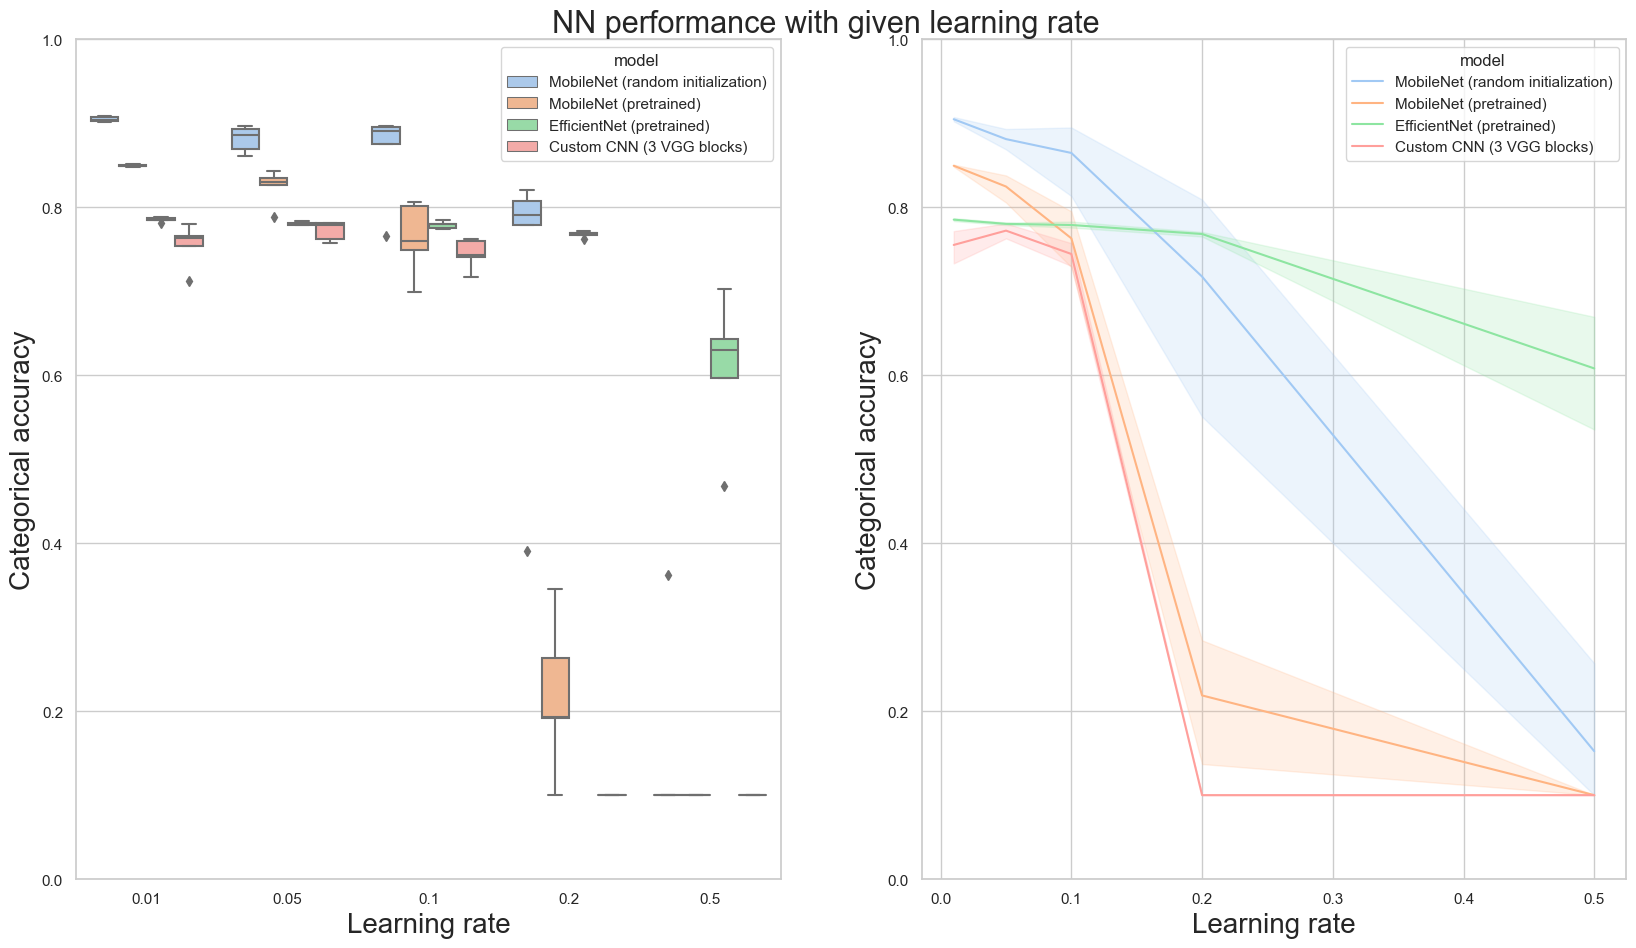

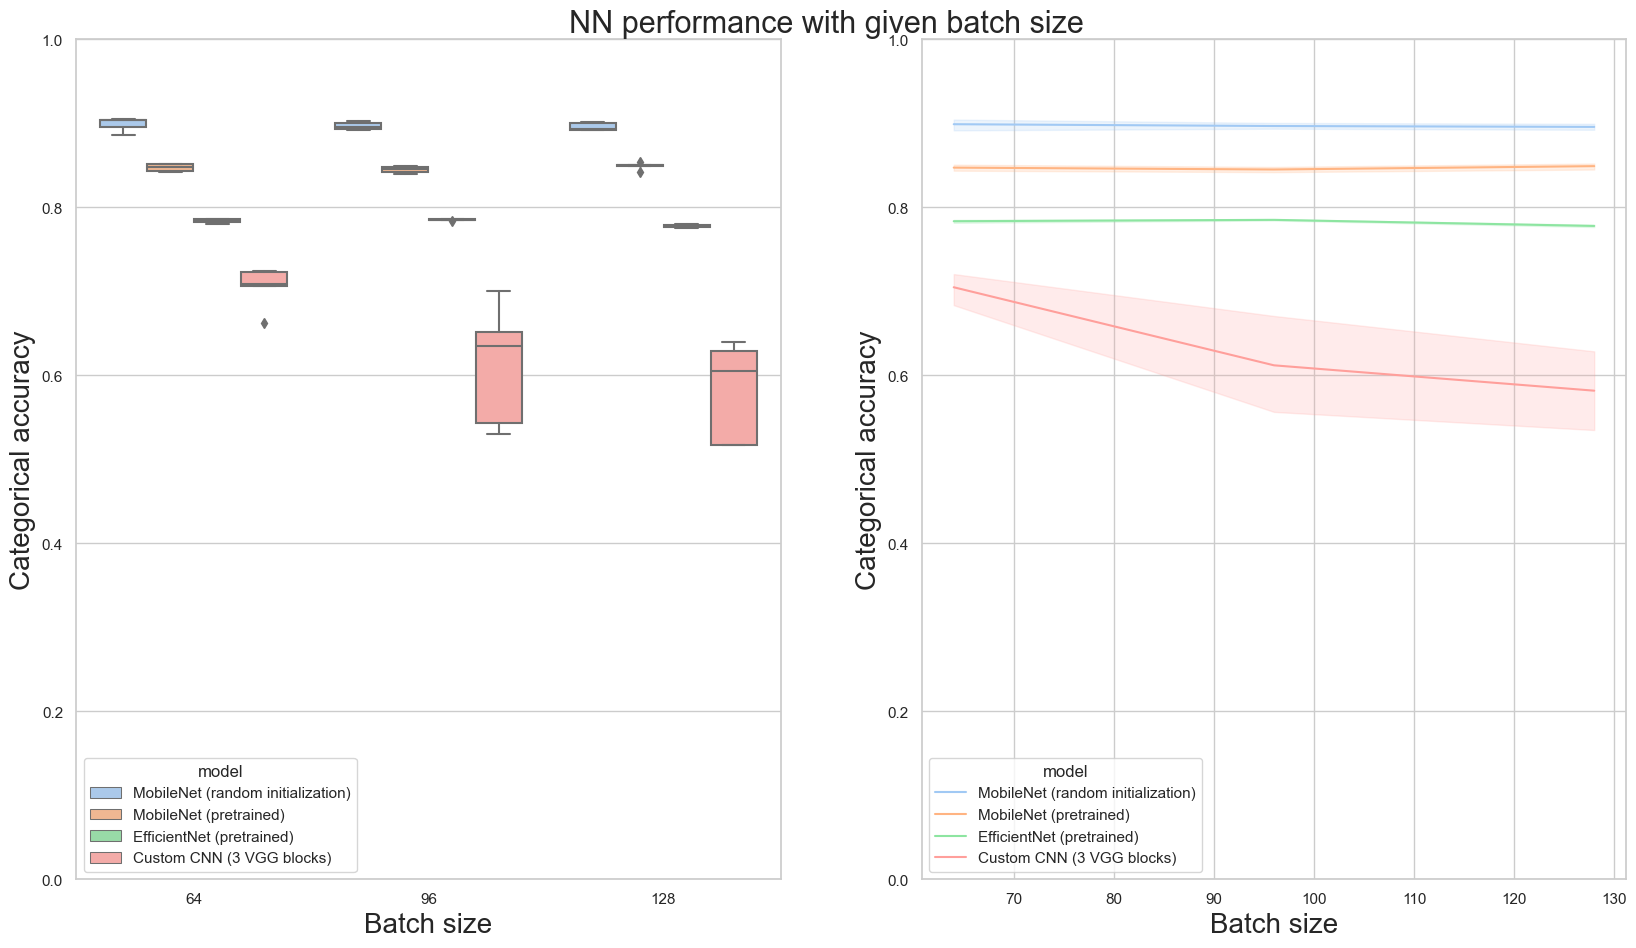

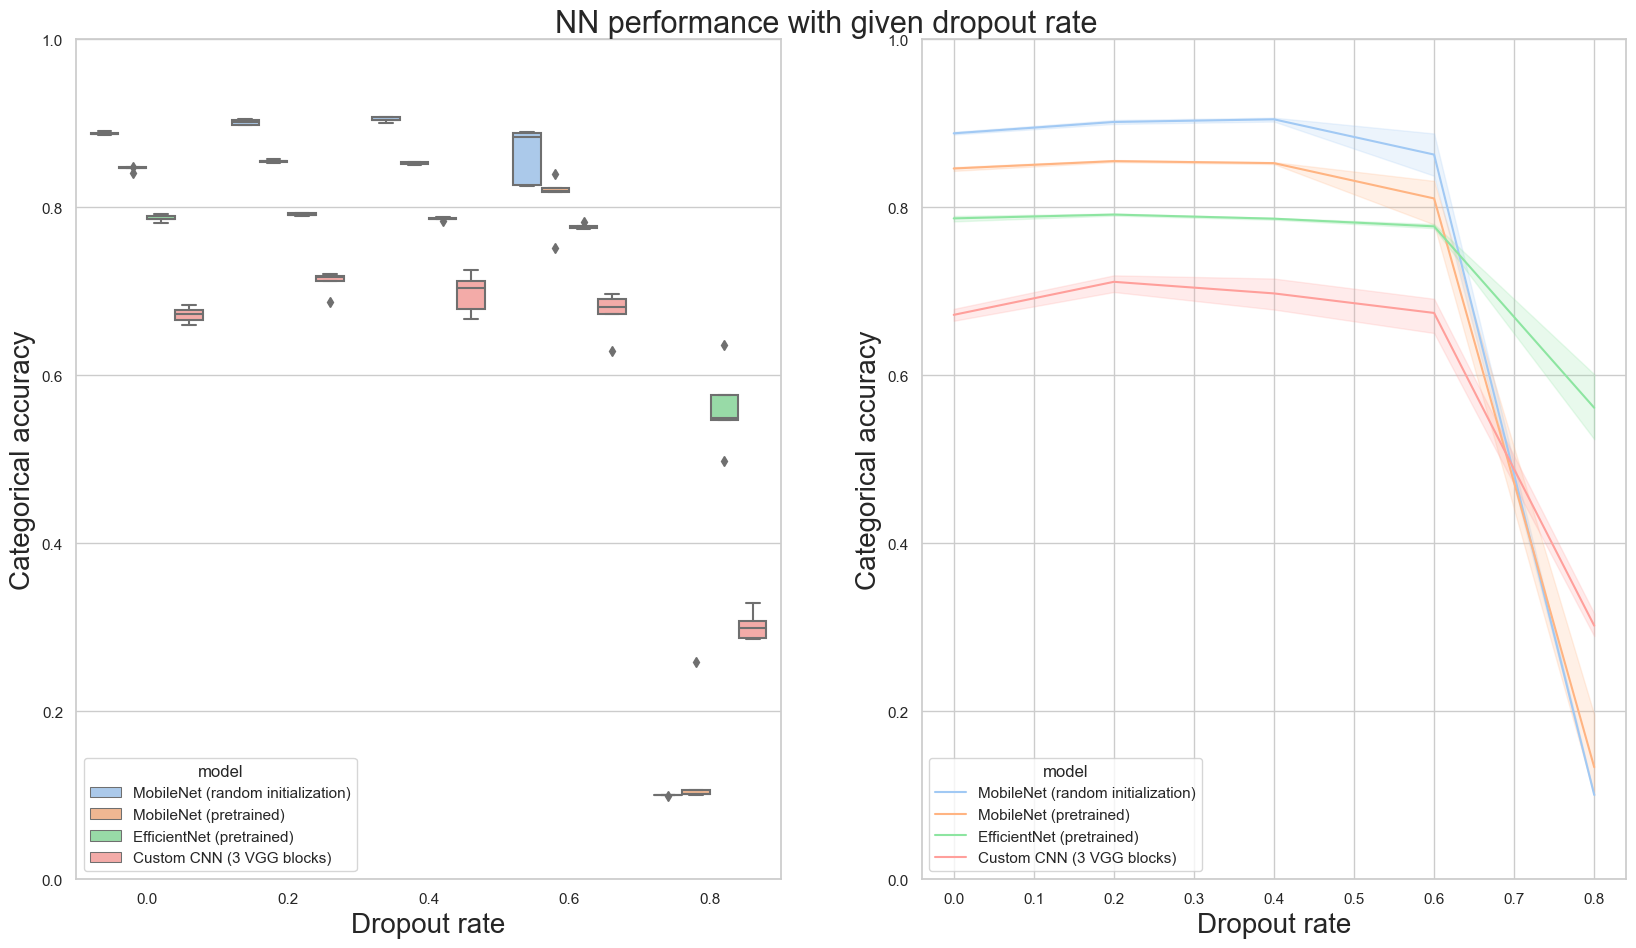

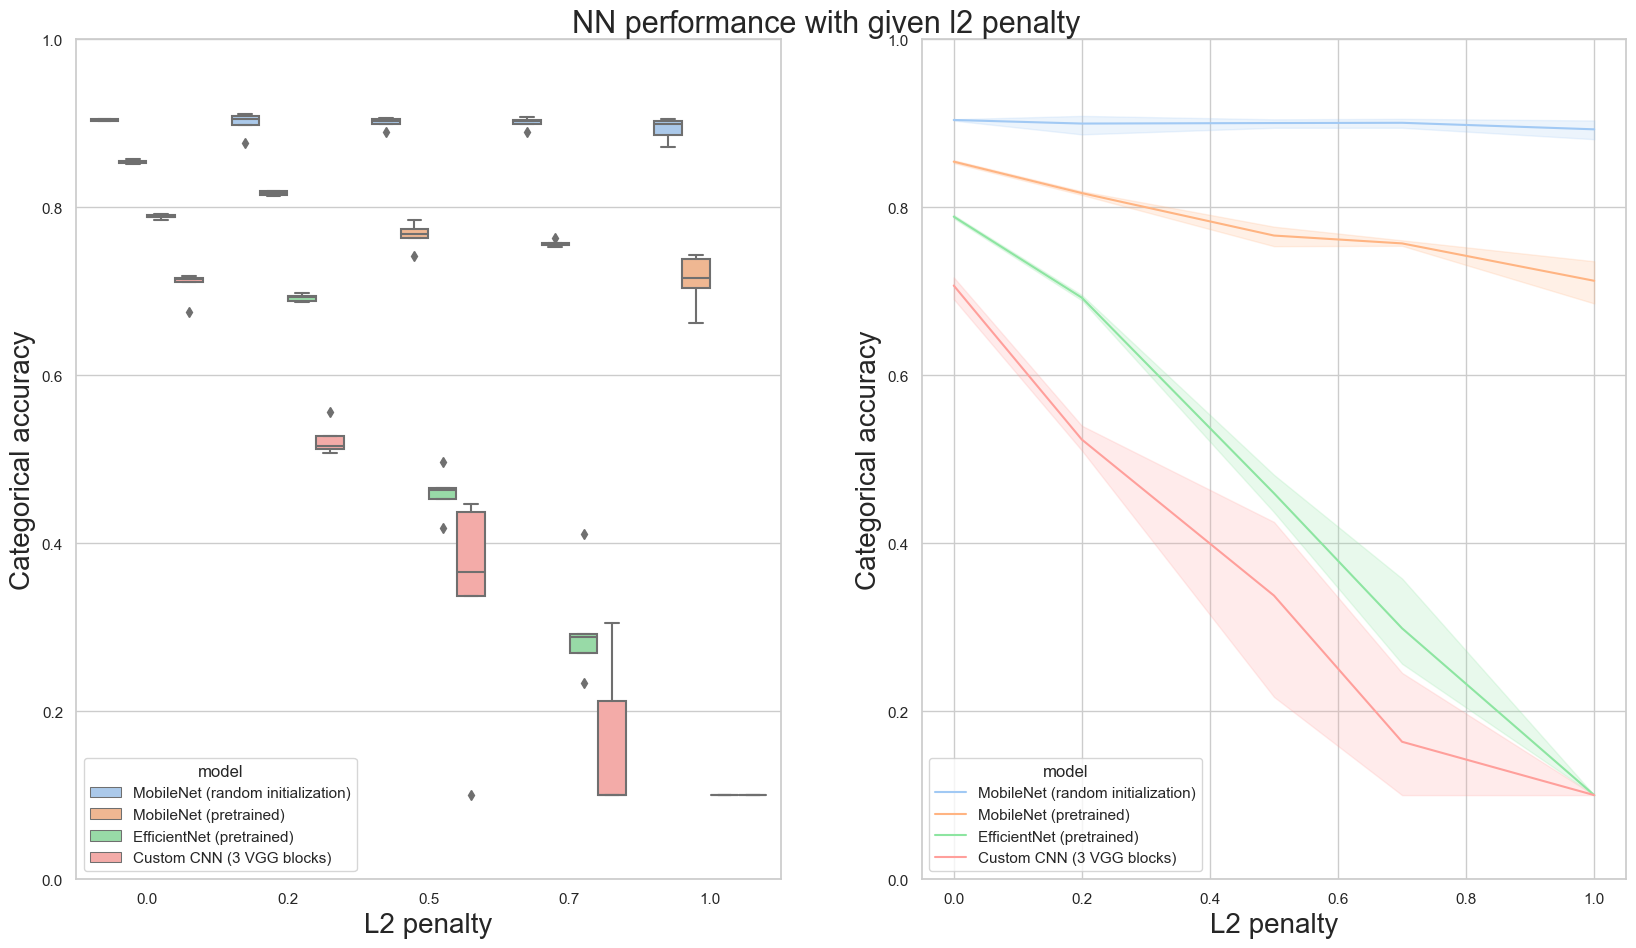

In [53]:
sns.set_theme(style="whitegrid", palette="pastel")
def visualize_results(results: pd.DataFrame, param_name: str, title: str = None):
    if title is None:
        title = param_name.capitalize().replace("_", " ")
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    g = []
    g.append(sns.boxplot(x = param_name, y = "categorical_accuracy", hue = "model", data = results, ax = ax[0]))
    g.append(sns.lineplot(x = param_name, y = "categorical_accuracy", hue = "model", data = results, ax = ax[1]))
    for plot in g:
        plot.set_xlabel(title, fontsize = 20)
        plot.set_ylabel("Categorical accuracy", fontsize = 20)
        plot.set_ylim(0, 1)
    fig.suptitle(f'NN performance with given {title.lower()}', fontsize=22)
    fig.subplots_adjust(top=0.95)

    plt.show()

visualize_results(lr_res, "learning_rate")
visualize_results(bs_res, "batch_size")
visualize_results(dr_res, "dropout_rate")
visualize_results(l2_res, "l2", "L2 penalty")

In [15]:
Experiment.select_feature_extractor('MobileNet (random initialization)')

## Experiment 2


**Description:** 

Investigate influence of at least X data augmentation techniques from the following groups:

• Standard operations (where x = 3),

• More advanced data augmentation techniques like mixup, cutmix, cutout (where x = 1).

**Solution:** 

To obtain meaningfull results we will consider all of the methods M1, M2, M3, and cutmix separately and all at once which will end up with us having 1 raw dataset, 4 datasets with singular augmentation method and one with all augmentation methods. As a result we will end up with 24 trained models. We will create a ranked list of models sorted by the categorical_accuracy, additionally we evaluate precision, and recall.

In [5]:
l2_res = pd.read_pickle('Eksperyment1/l2_res.pkl')

In [25]:
reps = 5
extract_best = result_extractor('categorical_accuracy')
aug_res = Experiment.run([Settings(**extract_best(l2_res), augmentation = aug) for aug in Experiment.augmentations.keys()], repeat_count = reps)

Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2, 'l2': 0.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2, 'l2': 0.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2, 'l2': 0.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2, 'l2': 0.0}
Current best grid search result: {'learning_rate': 0.01, 'batch_size': 64.0, 'dropout_rate': 0.2, 'l2': 0.0}
Building MobileNet (random initialization)...
Epoch 1/100
938/938 [==============================] - 31s 29ms/step - loss: 1.0009 - categorical_accuracy: 0.6810 - precision: 0.8201 - recall: 0.5741 - val_loss: 0.5785 - val_categorical_accuracy: 0.8228 - val_precision: 0.8740 - val_recall: 0.7764
Epoch 2/100
938/938 [==============================] - 26s 28ms/step - loss: 0.5259 - categorical_accuracy: 0.8316 - precision: 0.8887 - recall: 0.7762 - val_

In [31]:
save_object(aug_res, 'aug_res.pkl')

In [13]:
aug_res = pd.read_pickle('Eksperyment2/aug_res.pkl')

In [14]:
aug_addition = l2_res[l2_res['model'] == 'MobileNet (random initialization)']
aug_addition = aug_addition[aug_addition['l2'] == 0]
aug_addition['augmentation'] = ['None', 'None', 'None', 'None', 'None']
aug_addition
aug_res = pd.concat([aug_res, aug_addition]).reset_index(drop = True)
aug_res

,model,iteration,learning_rate,batch_size,dropout_rate,l2,augmentation,predictions,loss,categorical_accuracy,precision,recall
0,MobileNet (random initialization),0,0.01,64.0,0.2,0.0,shift,"[[3.23439e-10, 4.945943e-12, 1.4869711e-07, 0....",0.349080,0.9106,0.920004,0.9028
1,MobileNet (random initialization),1,0.01,64.0,0.2,0.0,shift,"[[6.708117e-11, 7.160406e-11, 2.0554624e-07, 0...",0.342456,0.9130,0.921240,0.9065
2,MobileNet (random initialization),2,0.01,64.0,0.2,0.0,shift,"[[1.7745407e-08, 6.450187e-08, 3.997062e-05, 0...",0.370266,0.9090,0.917268,0.9025
3,MobileNet (random initialization),3,0.01,64.0,0.2,0.0,shift,"[[4.4223574e-12, 7.3132375e-13, 4.0921197e-08,...",0.330582,0.9116,0.922425,0.9037
4,MobileNet (random initialization),4,0.01,64.0,0.2,0.0,shift,"[[1.2422169e-09, 7.838432e-11, 5.9977447e-07, ...",0.357464,0.9086,0.918211,0.9015
5,MobileNet (random initialization),0,0.01,64.0,0.2,0.0,crop,"[[1.3969338e-07, 2.132514e-08, 6.3019056e-06, ...",0.341807,0.9072,0.917754,0.9005
6,MobileNet (random initialization),1,0.01,64.0,0.2,0.0,crop,"[[1.9979383e-07, 5.6632175e-08, 4.6419295e-06,...",0.344702,0.9068,0.918474,0.8979
7,MobileNet (random initialization),2,0.01,64.0,0.2,0.0,crop,"[[6.875753e-10, 1.1652912e-10, 3.1297402e-06, ...",0.364965,0.9014,0.914146,0.8944
8,MobileNet (random initialization),3,0.01,64.0,0.2,0.0,crop,"[[7.735791e-13, 4.3879934e-12, 1.7522893e-07, ...",0.391854,0.9003,0.909721,0.8928
9,MobileNet (random initialization),4,0.01,64.0,0.2,0.0,crop,"[[1.923706e-07, 8.109048e-08, 1.1384557e-05, 0...",0.356056,0.9030,0.915526,0.8963


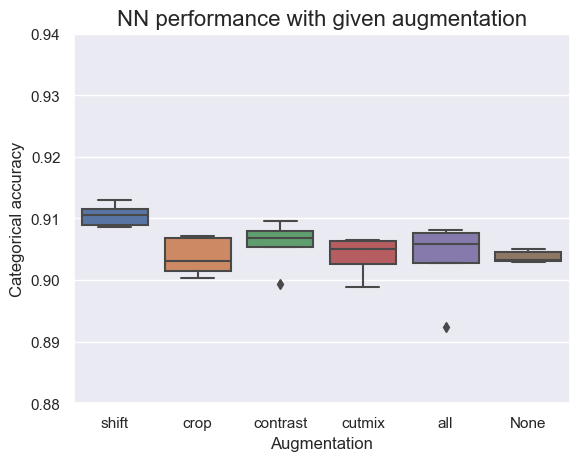

In [15]:
def visualize_augmentation_results(results: pd.DataFrame):
    fig = sns.boxplot(x = "augmentation", y = "categorical_accuracy", data = results)
    fig.set(
        xlabel = "Augmentation", 
        ylabel = "Categorical accuracy", 
        ylim = (0.88, 0.94)
    )
    fig.set_title(f'NN performance with given augmentation', fontsize=16)

    plt.show()
visualize_augmentation_results(aug_res)

## Experiment 3

**Description:** 

Consider application of ensemble (hard/soft voting, stacking).

**Solution:** 

During this stage we will compare the methods of hard and soft voting conducted on the set of models trained during the experiment 1.

In [3]:
l2_res  = pd.read_pickle('Eksperyment1/l2_res.pkl')
bs_res  = pd.read_pickle('Eksperyment1/bs_res.pkl')
dr_res  = pd.read_pickle('Eksperyment1/dr_res.pkl')
lr_res  = pd.read_pickle('Eksperyment1/lr_res.pkl')
aug_res = pd.read_pickle('Eksperyment2/aug_res.pkl')

In [9]:
def soft_voting(df):
    class_preds = []
    for j in range (df['predictions'][0].shape[0]): # we go through every observation
        class_probs = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for i in range(df.shape[0]): # and every model
            if (math.isnan(df['predictions'][i][j][0]) == False):
                class_probs = [x + y for x, y in zip(class_probs, df['predictions'][i][j])]
        class_probs = np.array(class_probs) / df.shape[0]
        class_pred  = list(class_probs).index(max(class_probs))
        class_preds.append(class_pred)
    return class_preds

def hard_voting(df):
    class_preds = []
    for j in range (df['predictions'][0].shape[0]): # we go through every observation
        class_pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for i in range(df.shape[0]): # and every model
            if (math.isnan(df['predictions'][i][j][0]) == False):
                class_probs = df['predictions'][i][j]
                minor_preds = list(class_probs).index(max(class_probs))
                class_pred[minor_preds] += 1
        p = list(class_pred).index(max(class_pred))
        class_preds.append(p)
    return class_preds


In [62]:
def unify_for_ensembles(df1, df2, df3, df4, df5):
    df1 = df1[['model', 'predictions', 'categorical_accuracy']]
    df2 = df2[['model', 'predictions', 'categorical_accuracy']]
    df3 = df3[['model', 'predictions', 'categorical_accuracy']]
    df4 = df4[['model', 'predictions', 'categorical_accuracy']]
    df5 = df5[['model', 'predictions', 'categorical_accuracy']]
    df  = pd.DataFrame(df1)
    df  = pd.concat([df, df2]).reset_index(drop = True)
    df  = pd.concat([df, df3]).reset_index(drop = True)
    df  = pd.concat([df, df4]).reset_index(drop = True)
    df  = pd.concat([df, df5]).reset_index(drop = True)
    return df

In [63]:
print('Full model ensemble')
ensemble_df = unify_for_ensembles(lr_res, bs_res, dr_res, l2_res, aug_res)

y_test_preds = []
for i in range(y_test.shape[0]):
    y_test_pred = list(y_test[i]).index(max(y_test[i]))
    y_test_preds.append(y_test_pred)

res = soft_voting(ensemble_df) 

accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy soft voting: ')
print(accuracy)

res = hard_voting(ensemble_df) 

accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy hard voting: ')
print(accuracy)

print('Categorical Accuracy for worst and best model: ')
print(min(ensemble_df['categorical_accuracy']), max(ensemble_df['categorical_accuracy']))

Full model ensemble
Categorical Accuracy soft voting: 
0.9217
Categorical Accuracy hard voting: 
0.9121
Categorical Accuracy for worst and best model: 
0.09950000047683716 0.9129999876022339


In [64]:
ensemble_df_10_perc = ensemble_df.sort_values('categorical_accuracy', ascending = False)[:38].reset_index(drop=True)
ensemble_df_20_perc = ensemble_df.sort_values('categorical_accuracy', ascending = False)[:38*2].reset_index(drop=True)
ensemble_df_30_perc = ensemble_df.sort_values('categorical_accuracy', ascending = False)[:38*3].reset_index(drop=True)
ensemble_df_40_perc = ensemble_df.sort_values('categorical_accuracy', ascending = False)[:38*4].reset_index(drop=True)
ensemble_df_50_perc = ensemble_df.sort_values('categorical_accuracy', ascending = False)[:38*5].reset_index(drop=True)

In [65]:
ensemble_df_10_perc

,model,predictions,categorical_accuracy
0,MobileNet (random initialization),"[[6.708117e-11, 7.160406e-11, 2.0554624e-07, 0...",0.9130
1,MobileNet (random initialization),"[[4.4223574e-12, 7.3132375e-13, 4.0921197e-08,...",0.9116
2,MobileNet (random initialization),"[[4.301864e-06, 4.492412e-05, 9.699021e-05, 0....",0.9108
3,MobileNet (random initialization),"[[3.23439e-10, 4.945943e-12, 1.4869711e-07, 0....",0.9106
4,MobileNet (random initialization),"[[7.883356e-12, 5.6163333e-15, 1.1217548e-08, ...",0.9095
5,MobileNet (random initialization),"[[1.7745407e-08, 6.450187e-08, 3.997062e-05, 0...",0.9090
6,MobileNet (random initialization),"[[4.821681e-11, 1.1147512e-08, 6.283335e-07, 0...",0.9087
7,MobileNet (random initialization),"[[1.2422169e-09, 7.838432e-11, 5.9977447e-07, ...",0.9086
8,MobileNet (random initialization),"[[1.5659221e-08, 6.0764606e-08, 1.6362912e-05,...",0.9081
9,MobileNet (random initialization),"[[1.1180566e-05, 2.785851e-08, 2.539854e-07, 0...",0.9080


In [66]:
print('Best 10% model ensemble')

res = soft_voting(ensemble_df_10_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('')
print('Categorical Accuracy soft voting: ')
print(accuracy)

res = hard_voting(ensemble_df_10_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy hard voting: ')
print(accuracy)

Best 10% model ensemble

Categorical Accuracy soft voting: 
0.9299
Categorical Accuracy hard voting: 
0.9307


In [67]:
print('Best 20% model ensemble')

res = soft_voting(ensemble_df_20_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy soft voting: ')
print(accuracy)

res = hard_voting(ensemble_df_20_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy hard voting: ')
print(accuracy)

Best 20% model ensemble
Categorical Accuracy soft voting: 
0.9286
Categorical Accuracy hard voting: 
0.9284


In [68]:
print('Best 30% model ensemble')

res = soft_voting(ensemble_df_30_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy soft voting: ')
print(accuracy)

res = hard_voting(ensemble_df_30_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy hard voting: ')
print(accuracy)

Best 30% model ensemble
Categorical Accuracy soft voting: 
0.9306
Categorical Accuracy hard voting: 
0.9304


In [69]:
print('Best 40% model ensemble')

res = soft_voting(ensemble_df_40_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy soft voting: ')
print(accuracy)

res = hard_voting(ensemble_df_40_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy hard voting: ')
print(accuracy)

Best 40% model ensemble
Categorical Accuracy soft voting: 
0.9271
Categorical Accuracy hard voting: 
0.9249


In [70]:
print('Best 50% model ensemble')

res = soft_voting(ensemble_df_50_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
res = soft_voting(ensemble_df_40_perc) 
print(accuracy)

res = hard_voting(ensemble_df_50_perc) 
accuracy = sum([x == y for x, y in zip(res, y_test_preds)]) / len(res)
print('Categorical Accuracy hard voting: ')
print(accuracy)

Best 50% model ensemble
0.9282
Categorical Accuracy hard voting: 
0.9252
